<a href="https://colab.research.google.com/github/minnie-0923/Minnie-Astrophysics/blob/main/GW150914_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GW150914 引力波数据分析
## 人类首次直接探测到的黑洞合并事件

2015年9月14日，LIGO探测到来自13亿光年外两个黑洞合并产生的引力波信号，这是人类历史上首次直接探测到引力波。

In [1]:
# 安装必要的库
!pip install gwpy matplotlib scipy numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.0 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.


In [2]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot


## 1. 数据获取

In [3]:
# 设置GW150914事件参数
t0 = 1126259462.4  # 事件发生时间 (GPS时间)
start_time = 1126259446  # 开始时间 (t0 - 16秒)
end_time = 1126259478    # 结束时间 (t0 + 16秒)

print(f"事件时间: {t0}")
print(f"数据时间范围: {start_time} 到 {end_time}")
print(f"持续时间: {end_time - start_time} 秒")

事件时间: 1126259462.4
数据时间范围: 1126259446 到 1126259478
持续时间: 32 秒


In [4]:
# 从GWOSC获取汉福德观测站数据
print("正在从GWOSC下载LIGO Hanford数据...")
hdata = TimeSeries.fetch_open_data('H1', start_time, end_time)

print(f"数据获取完成!")
print(f"数据点数: {len(hdata)}")
print(f"采样率: {hdata.sample_rate.value} Hz")
print(f"持续时间: {hdata.duration.value} 秒")
print(f"应变数据范围: {hdata.min():.2e} 到 {hdata.max():.2e}")

正在从GWOSC下载LIGO Hanford数据...
数据获取完成!
数据点数: 131072
采样率: 4096.0 Hz
持续时间: 32.0 秒
应变数据范围: -7.04e-19 到 7.71e-19


## 2. 频谱分析 - 振幅谱密度(ASD)

计算振幅谱密度...


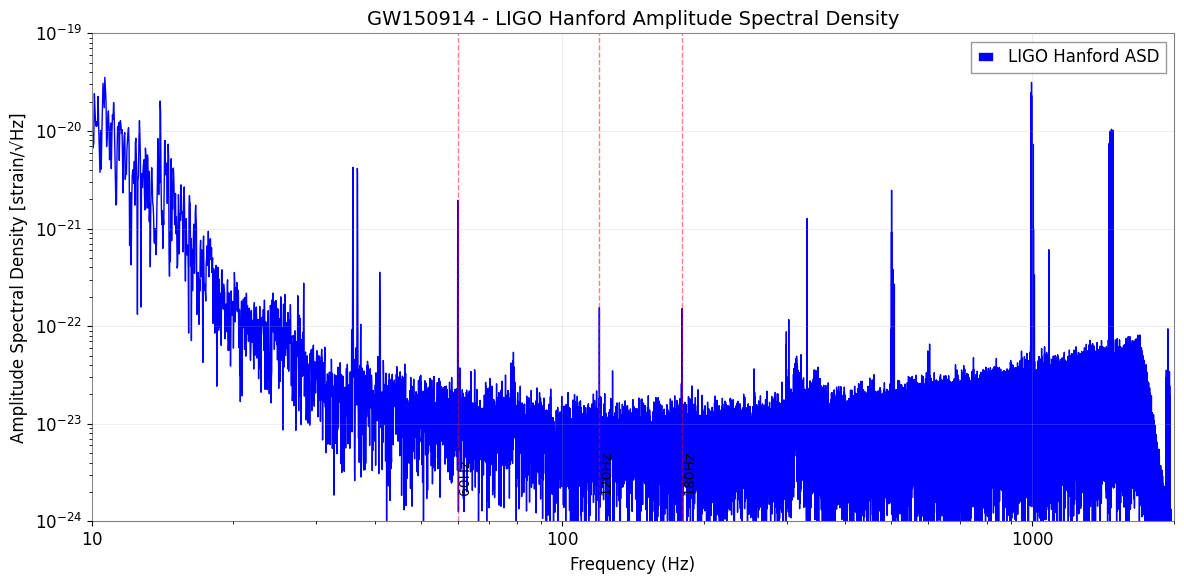

In [5]:
# 计算振幅谱密度
print("计算振幅谱密度...")
asd = hdata.asd()

# 绘制ASD图
plt.figure(figsize=(12, 6))
plt.plot(asd.frequencies, asd, 'b-', linewidth=1, label='LIGO Hanford ASD')
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Amplitude Spectral Density [strain/√Hz]', fontsize=12)
plt.title('GW150914 - LIGO Hanford Amplitude Spectral Density', fontsize=14)
plt.grid(True, alpha=0.3)

# 标记电源线干扰
for freq in [60, 120, 180]:
    plt.axvline(freq, color='red', linestyle='--', alpha=0.5, linewidth=1)
    plt.text(freq, 2e-24, f'{freq}Hz', rotation=90, fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

## 3. 信号滤波处理

In [6]:
# 设计滤波器
print("设计滤波器...")

# 带通滤波器：50-250Hz，保留引力波特征频段
bp = filter_design.bandpass(50, 250, hdata.sample_rate)

# 陷波滤波器：消除电源线干扰
notches = [filter_design.notch(line, hdata.sample_rate) for line in (60, 120, 180)]

# 合并所有滤波器
zpk = filter_design.concatenate_zpks(bp, *notches)

print("滤波器设计完成:")
print(f"  带通范围: 50-250 Hz")
print(f"  陷波频率: 60, 120, 180 Hz")

设计滤波器...
滤波器设计完成:
  带通范围: 50-250 Hz
  陷波频率: 60, 120, 180 Hz


In [7]:
# 应用滤波器
print("应用滤波器...")
hfilt = hdata.filter(zpk, filtfilt=True)

# 裁剪数据边界以避免边缘效应
hdata_cropped = hdata.crop(*hdata.span.contract(1))
hfilt_cropped = hfilt.crop(*hfilt.span.contract(1))

print("滤波完成!")
print(f"原始数据范围: {hdata.span}")
print(f"裁剪后范围: {hdata_cropped.span}")

应用滤波器...
滤波完成!
原始数据范围: [1126259446.0 ... 1126259478.0)
裁剪后范围: [1126259447.0 ... 1126259477.0)


## 4. 滤波效果可视化

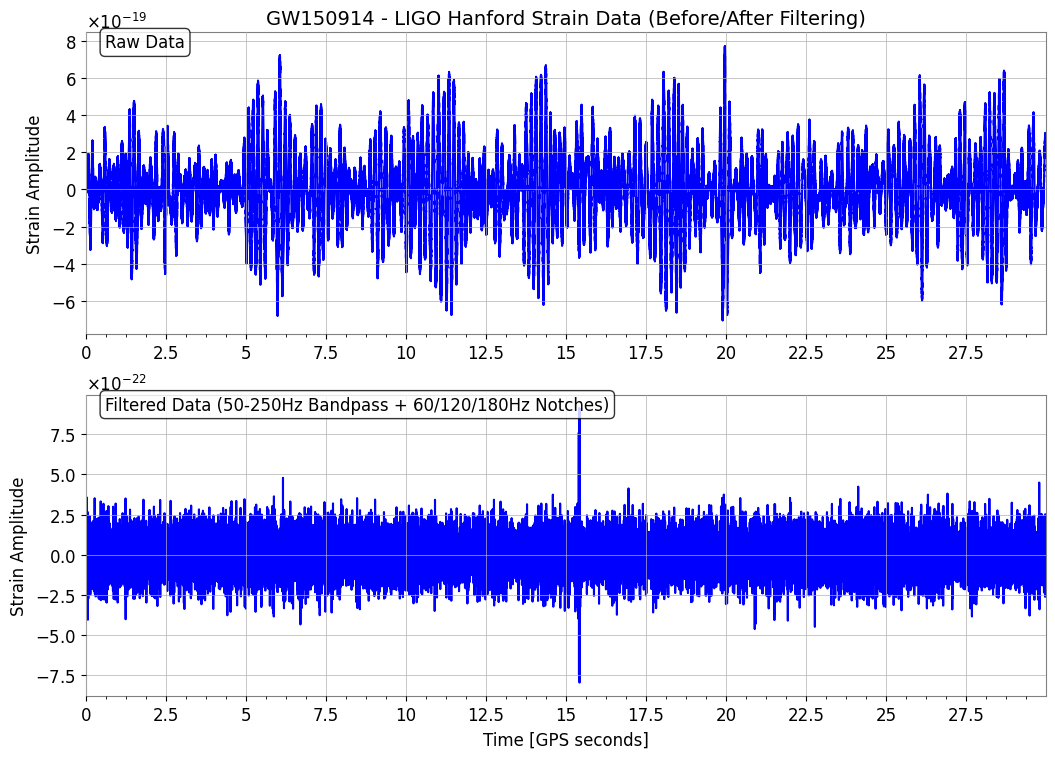

In [8]:
# 绘制滤波前后对比
plot = Plot(
    hdata_cropped,
    hfilt_cropped,
    figsize=[12, 8],
    separate=True,
    sharex=True,
    color='blue'
)

ax1, ax2 = plot.axes

ax1.set_title('GW150914 - LIGO Hanford Strain Data (Before/After Filtering)', fontsize=14)
ax1.text(0.02, 0.95, 'Raw Data', transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
ax1.set_ylabel('Strain Amplitude', fontsize=12)

ax2.text(0.02, 0.95, 'Filtered Data (50-250Hz Bandpass + 60/120/180Hz Notches)',
         transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
ax2.set_ylabel('Strain Amplitude', fontsize=12)
ax2.set_xlabel('Time [GPS seconds]', fontsize=12)

plot.show()

## 5. 频谱对比分析

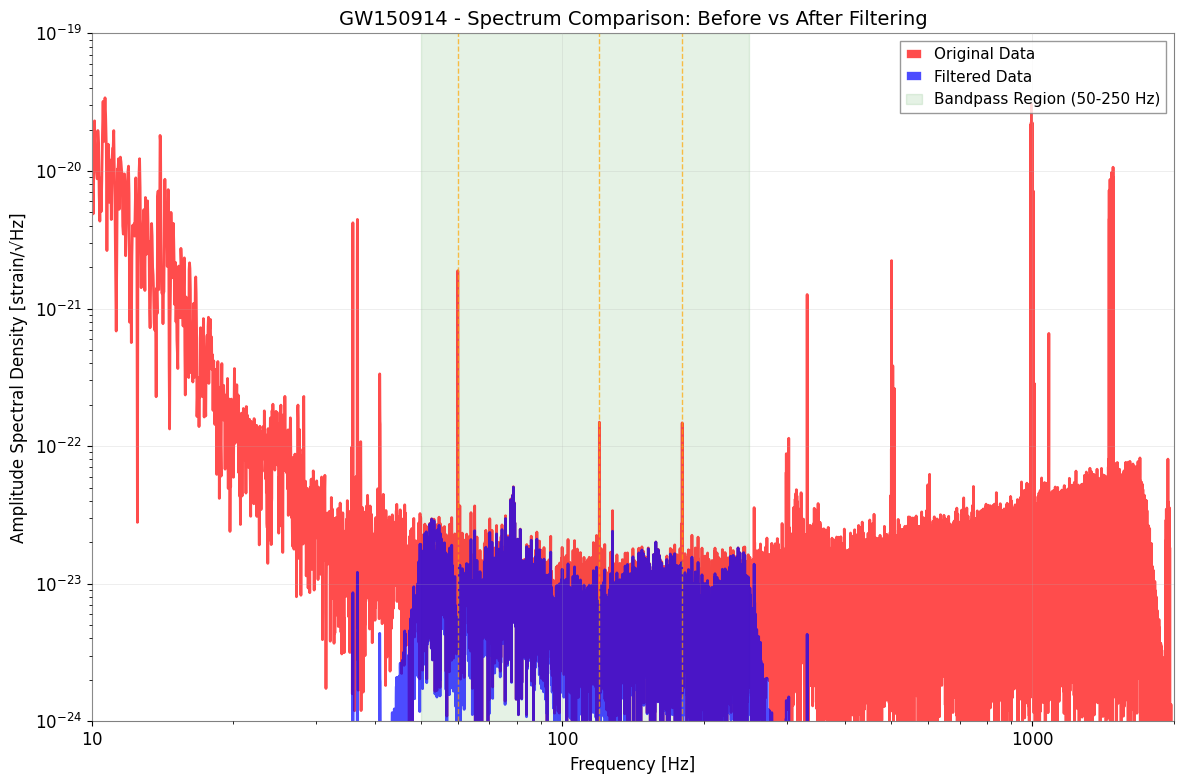

In [9]:
# 比较滤波前后的频谱
plt.figure(figsize=[12, 8])

# 计算ASD
asd_original = hdata_cropped.asd()
asd_filtered = hfilt_cropped.asd()

# Plot comparison
plt.plot(asd_original.frequencies, asd_original,
         label='Original Data', color='red', alpha=0.7, linewidth=2)
plt.plot(asd_filtered.frequencies, asd_filtered,
         label='Filtered Data', color='blue', alpha=0.7, linewidth=2)

plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Amplitude Spectral Density [strain/√Hz]', fontsize=12)
plt.title('GW150914 - Spectrum Comparison: Before vs After Filtering', fontsize=14)

# Mark important regions
plt.axvspan(50, 250, alpha=0.1, color='green', label='Bandpass Region (50-250 Hz)')

for freq in [60, 120, 180]:
    plt.axvline(freq, linestyle="--", color="orange", alpha=0.7, linewidth=1)

plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

## 6. 事件附近信号细节

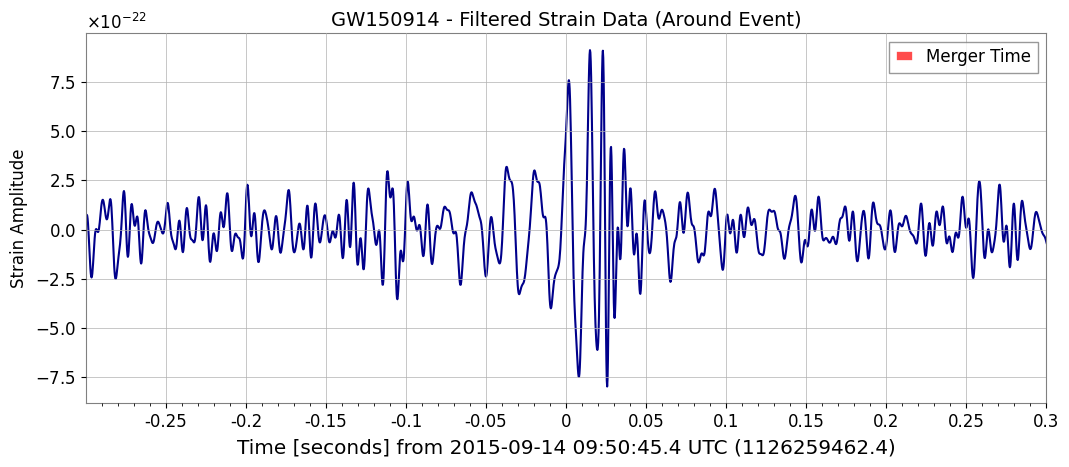

In [10]:
# 聚焦在事件发生的关键时刻
plot = hfilt_cropped.plot(color='darkblue', figsize=[12, 5])
ax = plot.gca()

# 设置显示范围：事件前后0.5秒
ax.set_xlim(t0 - 0.3, t0 + 0.3)
ax.set_xscale('seconds', epoch=t0)  # 以事件时间为零点

ax.set_ylabel('Strain Amplitude', fontsize=12)
ax.set_title('GW150914 - Filtered Strain Data (Around Event)', fontsize=14)

# 标记事件发生时刻
ax.axvline(0, color='red', linestyle='-', alpha=0.7, linewidth=2, label='Merger Time')
ax.legend()

plot.show()

# 提取数据用于后续分析
x_val = plt.gca().lines[0].get_xdata()
y_val = plt.gca().lines[0].get_ydata()

## 7. 多观测站数据对比

In [11]:
# 获取利文斯顿观测站数据
print("下载LIGO Livingston数据...")
ldata = TimeSeries.fetch_open_data('L1', start_time, end_time)

# 应用相同的滤波器
lfilt = ldata.filter(zpk, filtfilt=True)
lfilt = lfilt.crop(*lfilt.span.contract(1))

# 对L1数据进行时间偏移和相位调整
lfilt.shift('6.9ms')  # 补偿信号到达时间差
lfilt *= -1  # 调整相位（探测器方向不同）

print("利文斯顿数据处理完成!")

下载LIGO Livingston数据...
利文斯顿数据处理完成!


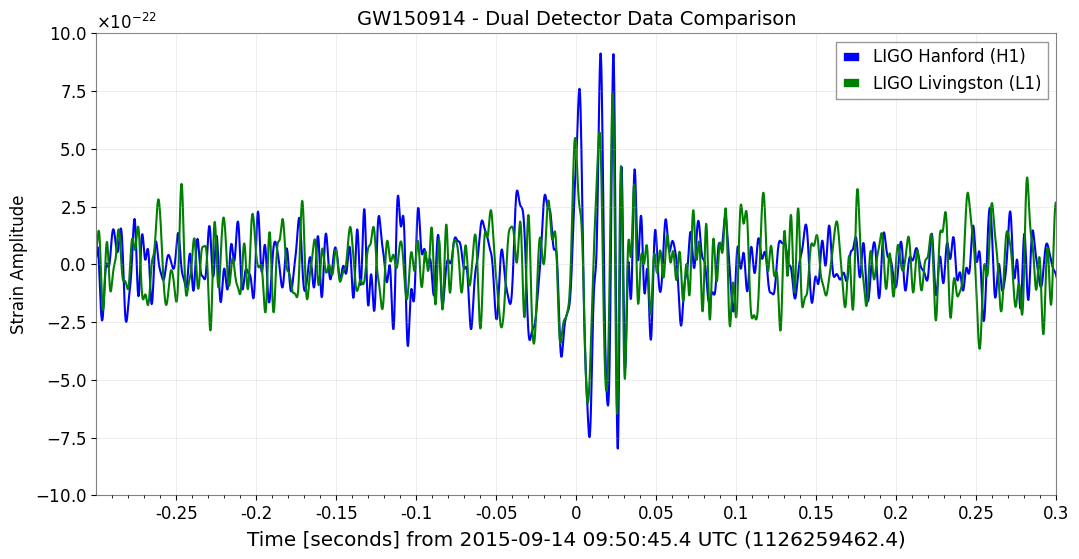

In [12]:
# 绘制双站数据对比
plot = Plot(figsize=[12, 6])
ax = plot.gca()

ax.plot(hfilt_cropped, label='LIGO Hanford (H1)', color='blue', linewidth=1.5)
ax.plot(lfilt, label='LIGO Livingston (L1)', color='green', linewidth=1.5)

ax.set_xlim(t0 - 0.3, t0 + 0.3)
ax.set_xscale('seconds', epoch=t0)
ax.set_ylabel('Strain Amplitude', fontsize=12)
ax.set_ylim(-1e-21, 1e-21)
ax.set_title('GW150914 - Dual Detector Data Comparison', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plot.show()

## 8. Q变换时频分析

进行Q变换时频分析...


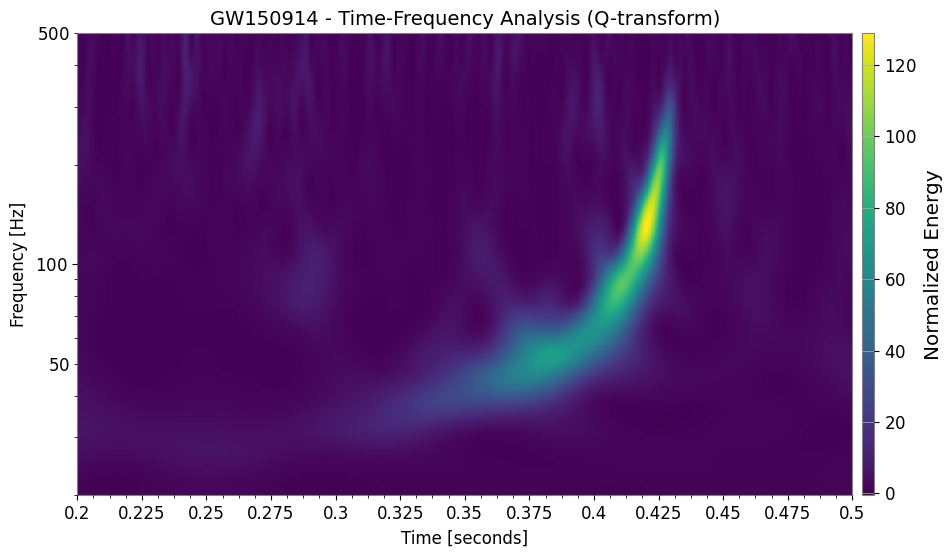

In [13]:
# 进行Q变换分析
print("进行Q变换时频分析...")

# 聚焦在事件前后0.2秒
hq = hfilt_cropped.q_transform(outseg=(t0-0.2, t0+0.1))
plot = hq.plot(figsize=[10, 6])

ax = plot.gca()
plot.colorbar(label="Normalized Energy", ax=ax)
ax.grid(False)
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_title('GW150914 - Time-Frequency Analysis (Q-transform)', fontsize=14)
ax.set_ylabel('Frequency [Hz]', fontsize=12)
ax.set_xlabel('Time [seconds]', fontsize=12)

plot.show()

## 9. 生成引力波音频

生成引力波音频...
音频文件已生成: GW150914_gravitational_wave.wav
采样率: 4096 Hz
持续时间: 3.00 秒
数据点数: 12288


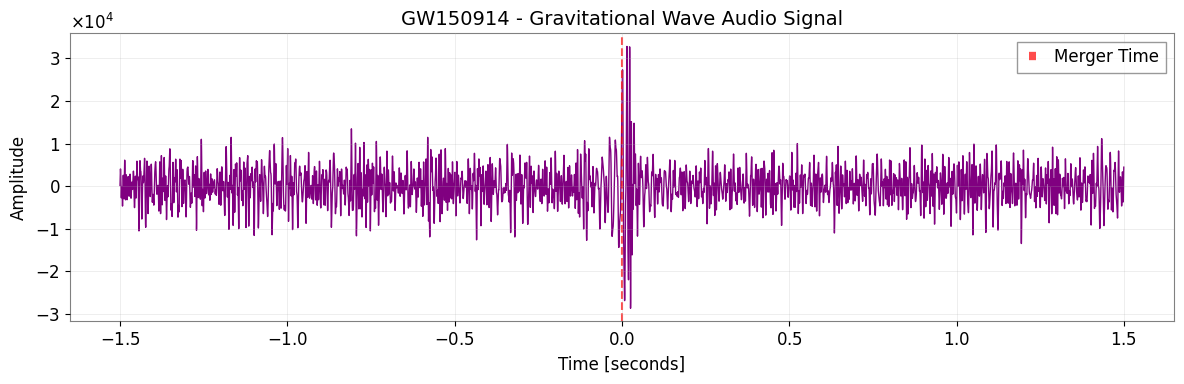

In [14]:
# 将引力波信号转换为音频
print("生成引力波音频...")

# 提取事件前后1.5秒的数据
time_window = 1.5
ind = np.where((x_val < (t0 + time_window)) & (x_val > (t0 - time_window)))
y_audio = y_val[ind]

# 信号归一化
y_audio = y_audio / np.max(np.abs(y_audio))

# 计算采样率
fs = int(1 / np.median(np.diff(x_val[ind])))

# 生成WAV文件
amplitude = np.iinfo(np.int16).max
audio_data = (y_audio * amplitude).astype(np.int16)

filename = "GW150914_gravitational_wave.wav"
write(filename, fs, audio_data)

print(f"音频文件已生成: {filename}")
print(f"采样率: {fs} Hz")
print(f"持续时间: {len(audio_data)/fs:.2f} 秒")
print(f"数据点数: {len(audio_data)}")

# 绘制音频信号
plt.figure(figsize=(12, 4))
time_audio = np.linspace(-time_window, time_window, len(audio_data))
plt.plot(time_audio, audio_data, 'purple', linewidth=1)
plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Merger Time')
plt.xlabel('Time [seconds]', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('GW150914 - Gravitational Wave Audio Signal', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()